In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from PIL import Image
import json
from tqdm.auto import tqdm
import shutil
from collections import Counter

# Deep Learning
import torch
import torchvision
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Configuration
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

project_root = Path.cwd().parent
print(f"📂 Répertoire projet: {project_root}")
print(f"🔥 PyTorch: {torch.__version__}")
print(f"🖼️ Torchvision: {torchvision.__version__}")

e:\Master data science\MPDS3_2025\projet federal\projet\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📂 Répertoire projet: e:\Master data science\MPDS3_2025\projet federal\projet
🔥 PyTorch: 2.9.0+cpu
🖼️ Torchvision: 0.24.0+cpu


In [3]:
# Paramètres globaux
CONFIG = {
    'IMAGE_SIZE': (224, 224),  # Nouvelle taille haute résolution
    'BATCH_SIZE': 32,
    'NUM_WORKERS': 4,
    'SEED': 42,
    
    # Chemins
    'DATA_RAW': project_root / 'data' / 'processed',
    'DATA_AUGMENTED': project_root / 'data' / 'augmented',
    
    # Classes (selon structure observée)
    'CLASSES': ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented'],
    
    # Target pour équilibrage
    'TARGET_SAMPLES_PER_CLASS': 6000,  # Augmenter la classe minoritaire
    
    # Modèle
    'MODEL_NAME': 'resnet152',  # ou 'resnet101'
}

# Créer dossiers de sortie
CONFIG['DATA_AUGMENTED'].mkdir(parents=True, exist_ok=True)

# Seed pour reproductibilité
np.random.seed(CONFIG['SEED'])
torch.manual_seed(CONFIG['SEED'])

print("✅ Configuration chargée")
print(json.dumps({k: str(v) for k, v in CONFIG.items()}, indent=2))

✅ Configuration chargée
{
  "IMAGE_SIZE": "(224, 224)",
  "BATCH_SIZE": "32",
  "NUM_WORKERS": "4",
  "SEED": "42",
  "DATA_RAW": "e:\\Master data science\\MPDS3_2025\\projet federal\\projet\\data\\processed",
  "DATA_AUGMENTED": "e:\\Master data science\\MPDS3_2025\\projet federal\\projet\\data\\augmented",
  "CLASSES": "['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']",
  "TARGET_SAMPLES_PER_CLASS": "6000",
  "MODEL_NAME": "resnet152"
}



📊 ANALYSE DE LA DISTRIBUTION DES CLASSES
  📁 NonDemented          :  8397 images
  📁 VeryMildDemented     :  4080 images
  📁 MildDemented         :  1665 images
  📁 ModerateDemented     :    64 images

📈 Statistiques:
                  Count  Percentage  Target  To_Generate
NonDemented        8397       59.11    6000            0
VeryMildDemented   4080       28.72    6000         1920
MildDemented       1665       11.72    6000         4335
ModerateDemented     64        0.45    6000         5936


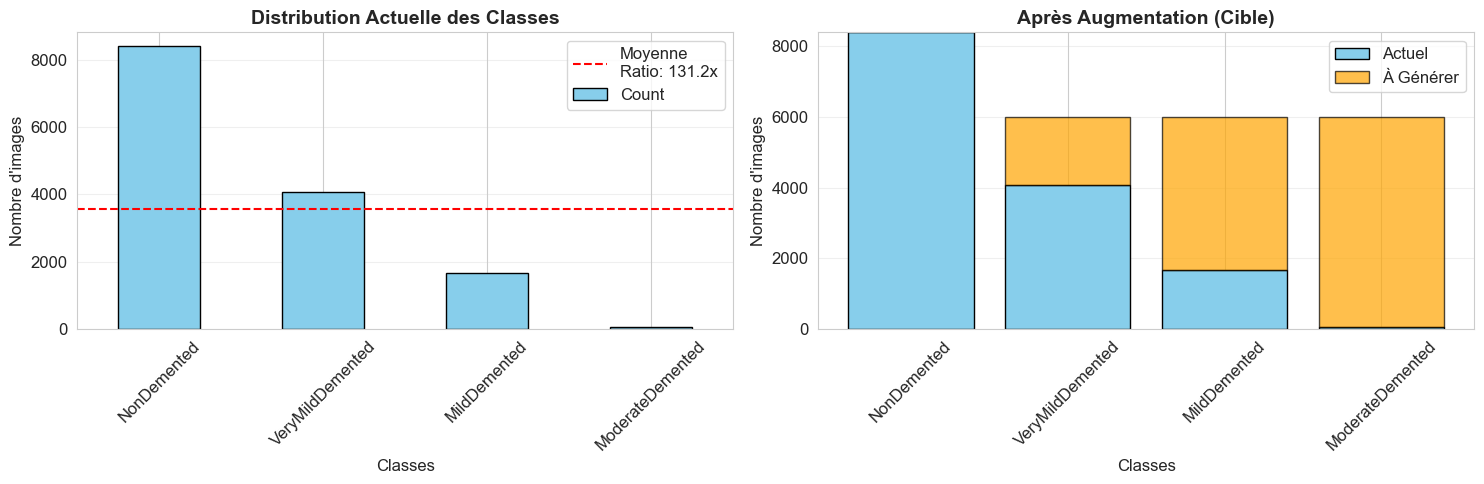

In [4]:
def analyze_class_distribution():
    """Analyse la distribution actuelle des classes"""
    
    print("\n📊 ANALYSE DE LA DISTRIBUTION DES CLASSES")
    print("=" * 60)
    
    class_counts = {}
    
    # Analyser train/
    train_path = CONFIG['DATA_RAW'] / 'train'
    
    if not train_path.exists():
        print("❌ Dossier train/ non trouvé")
        return None
    
    for class_name in CONFIG['CLASSES']:
        class_path = train_path / class_name
        if class_path.exists():
            count = len(list(class_path.glob('*.jpg'))) + len(list(class_path.glob('*.png')))
            class_counts[class_name] = count
            print(f"  📁 {class_name:20} : {count:5} images")
    
    # Créer DataFrame
    df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
    df['Percentage'] = (df['Count'] / df['Count'].sum() * 100).round(2)
    df['Target'] = CONFIG['TARGET_SAMPLES_PER_CLASS']
    df['To_Generate'] = df['Target'] - df['Count']
    df['To_Generate'] = df['To_Generate'].clip(lower=0)
    
    print(f"\n📈 Statistiques:")
    print(df)
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Distribution actuelle
    df['Count'].plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
    axes[0].set_title('Distribution Actuelle des Classes', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Nombre d\'images')
    axes[0].set_xlabel('Classes')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Déséquilibre
    imbalance = df['Count'].max() / df['Count'].min()
    axes[0].axhline(y=df['Count'].mean(), color='red', linestyle='--', 
                    label=f'Moyenne\nRatio: {imbalance:.1f}x')
    axes[0].legend()
    
    # Après augmentation
    target_counts = [CONFIG['TARGET_SAMPLES_PER_CLASS']] * len(df)
    axes[1].bar(df.index, df['Count'], label='Actuel', color='skyblue', edgecolor='black')
    axes[1].bar(df.index, df['To_Generate'], bottom=df['Count'], 
                label='À Générer', color='orange', edgecolor='black', alpha=0.7)
    axes[1].set_title('Après Augmentation (Cible)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Nombre d\'images')
    axes[1].set_xlabel('Classes')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(project_root / 'figures' / 'class_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df

class_stats = analyze_class_distribution()

In [5]:
def get_augmentation_pipeline(mode='train'):
    """
    Pipeline d'augmentation adapté pour les images médicales (IRM cérébrales)
    Conserve l'intégrité anatomique tout en augmentant la variabilité
    """
    
    if mode == 'train':
        return A.Compose([
            # Redimensionnement à haute résolution
            A.Resize(CONFIG['IMAGE_SIZE'][0], CONFIG['IMAGE_SIZE'][1]),
            
            # Transformations géométriques légères (préserver anatomie)
            A.HorizontalFlip(p=0.5),  # Symétrie cérébrale acceptable
            A.Rotate(limit=10, p=0.3),  # Rotation légère
            A.ShiftScaleRotate(
                shift_limit=0.05,
                scale_limit=0.1,
                rotate_limit=10,
                p=0.3
            ),
            
            # Transformations d'intensité (qualité scanner)
            A.RandomBrightnessContrast(
                brightness_limit=0.2,
                contrast_limit=0.2,
                p=0.5
            ),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),  # Bruit scanner
            A.GaussianBlur(blur_limit=(3, 5), p=0.2),  # Flou léger
            
            # Normalisation ImageNet (pour ResNet)
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ])
    
    else:  # validation/test
        return A.Compose([
            A.Resize(CONFIG['IMAGE_SIZE'][0], CONFIG['IMAGE_SIZE'][1]),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ])

# Test de la pipeline
print("\n🔄 PIPELINE D'AUGMENTATION")
print("=" * 60)
print("\n✅ Pipeline d'entraînement:")
train_aug = get_augmentation_pipeline('train')
print(train_aug)

print("\n✅ Pipeline de validation:")
val_aug = get_augmentation_pipeline('val')
print(val_aug)


🔄 PIPELINE D'AUGMENTATION

✅ Pipeline d'entraînement:
Compose([
  Resize(p=1.0, area_for_downscale=None, height=400, interpolation=1, mask_interpolation=0, width=400),
  HorizontalFlip(p=0.5),
  Rotate(p=0.3, border_mode=0, crop_border=False, fill=0.0, fill_mask=0.0, interpolation=1, limit=(-10.0, 10.0), mask_interpolation=0, rotate_method='largest_box'),
  ShiftScaleRotate(p=0.3, shift_limit_x=(-0.05, 0.05), shift_limit_y=(-0.05, 0.05), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-10.0, 10.0), interpolation=1, border_mode=0, fill=0.0, fill_mask=0.0, rotate_method='largest_box', mask_interpolation=0),
  RandomBrightnessContrast(p=0.5, brightness_by_max=True, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), ensure_safe_range=False),
  GaussNoise(p=0.3, mean_range=(0.0, 0.0), noise_scale_factor=1.0, per_channel=True, std_range=(0.2, 0.44)),
  GaussianBlur(p=0.2, blur_limit=(3, 5), sigma_limit=(0.5, 3.0)),
  Normalize(p=1.0, max_pixel_value=255.0, mean

e:\Master data science\MPDS3_2025\projet federal\projet\.venv\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\adnan\AppData\Local\Temp\ipykernel_21180\783011139.py:28: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),  # Bruit scanner



🔍 Visualisation pour: NonDemented


C:\Users\adnan\AppData\Local\Temp\ipykernel_21180\824416263.py:14: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


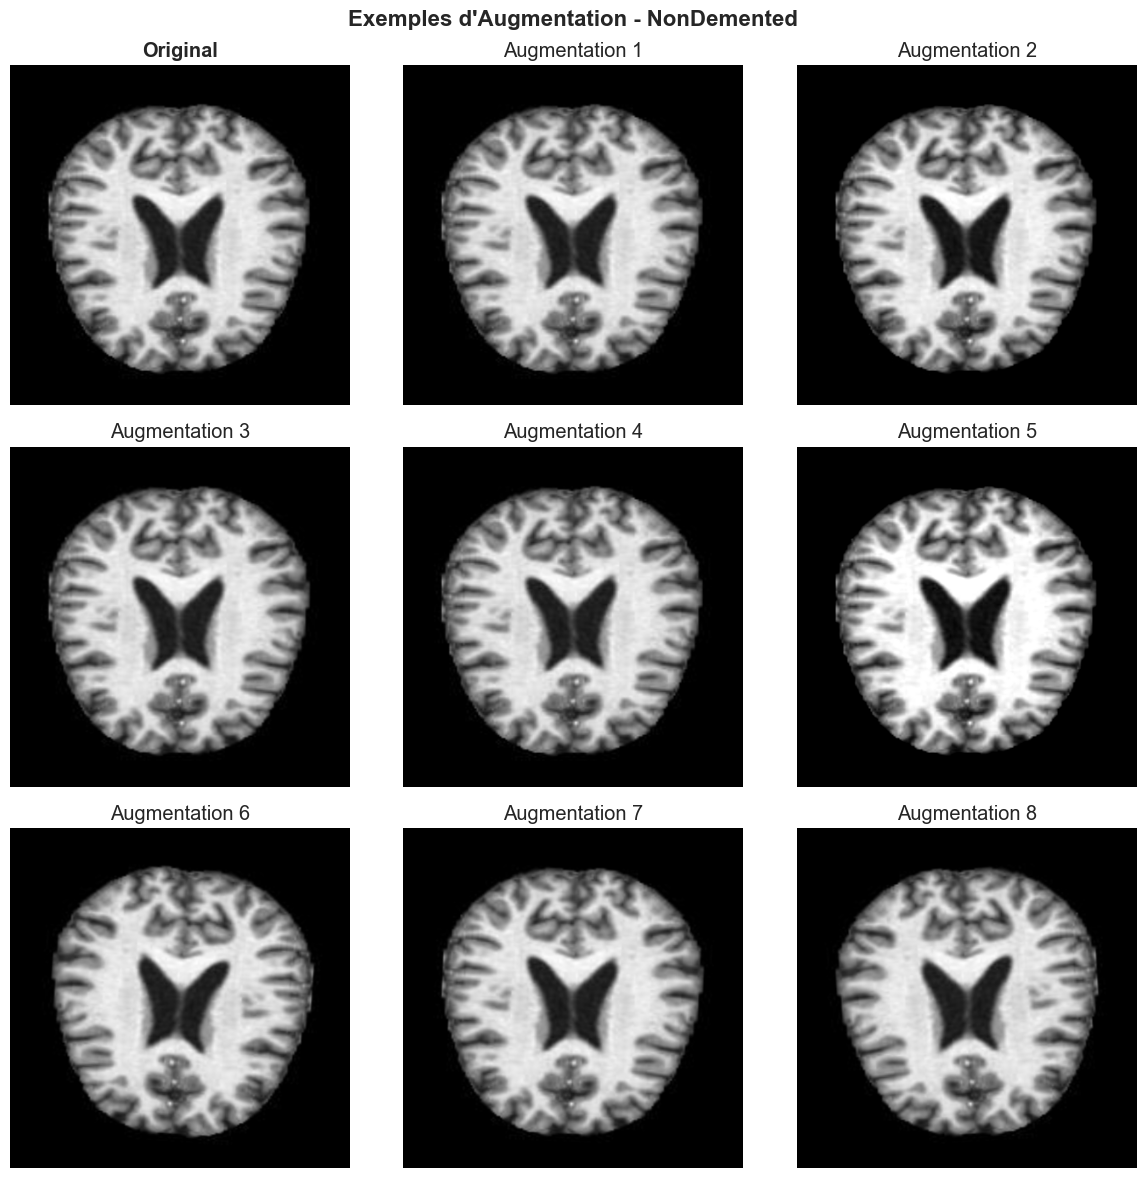

In [6]:
def visualize_augmentations(image_path, n_augmentations=8):
    """Visualise l'effet des augmentations sur une image"""
    
    # Charger image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Pipeline sans normalisation pour visualisation
    aug_pipeline = A.Compose([
        A.Resize(CONFIG['IMAGE_SIZE'][0], CONFIG['IMAGE_SIZE'][1]),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=10, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    ])
    
    # Créer figure
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    
    # Image originale
    original = cv2.resize(image, CONFIG['IMAGE_SIZE'])
    axes[0].imshow(original)
    axes[0].set_title('Original', fontweight='bold')
    axes[0].axis('off')
    
    # Augmentations
    for i in range(1, n_augmentations + 1):
        augmented = aug_pipeline(image=image)['image']
        axes[i].imshow(augmented)
        axes[i].set_title(f'Augmentation {i}')
        axes[i].axis('off')
    
    plt.suptitle(f'Exemples d\'Augmentation - {image_path.parent.name}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(project_root / 'figures' / 'augmentation_examples.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

# Visualiser pour chaque classe
train_path = CONFIG['DATA_RAW'] / 'train'
for class_name in CONFIG['CLASSES']:
    class_path = train_path / class_name
    if class_path.exists():
        sample_images = list(class_path.glob('*.jpg'))[:1]
        if sample_images:
            print(f"\n🔍 Visualisation pour: {class_name}")
            visualize_augmentations(sample_images[0], n_augmentations=8)
            break  # Une seule classe pour l'exemple

In [7]:
def generate_augmented_dataset():
    """
    Génère le dataset augmenté avec équilibrage des classes
    """
    
    print("\n🚀 GÉNÉRATION DU DATASET AUGMENTÉ")
    print("=" * 60)
    
    aug_pipeline = get_augmentation_pipeline('train')
    
    for split in ['train', 'val', 'test']:
        print(f"\n📁 Traitement de {split.upper()}...")
        
        source_path = CONFIG['DATA_RAW'] / split
        target_path = CONFIG['DATA_AUGMENTED'] / split
        
        if not source_path.exists():
            print(f"  ⚠️  Dossier {split}/ non trouvé, skip")
            continue
        
        for class_name in CONFIG['CLASSES']:
            class_source = source_path / class_name
            class_target = target_path / class_name
            
            if not class_source.exists():
                continue
                
            class_target.mkdir(parents=True, exist_ok=True)
            
            # Lister images source
            source_images = list(class_source.glob('*.jpg')) + list(class_source.glob('*.png'))
            n_source = len(source_images)
            
            if split == 'train':
                # Équilibrage pour train
                target_count = CONFIG['TARGET_SAMPLES_PER_CLASS']
                n_augmentations_per_image = max(1, target_count // n_source)
            else:
                # Pas d'augmentation pour val/test, juste redimensionnement
                target_count = n_source
                n_augmentations_per_image = 1
            
            print(f"\n  🔹 {class_name}:")
            print(f"     Source: {n_source} images")
            print(f"     Cible: {target_count} images")
            print(f"     Augmentations par image: {n_augmentations_per_image}")
            
            # Générer
            generated_count = 0
            
            for img_path in tqdm(source_images, desc=f"  {class_name}"):
                # Charger image
                image = cv2.imread(str(img_path))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # Générer augmentations
                for aug_idx in range(n_augmentations_per_image):
                    if generated_count >= target_count:
                        break
                    
                    # Appliquer augmentation
                    if split == 'train' and aug_idx > 0:
                        # Augmentation complète pour train
                        augmented = aug_pipeline(image=image)['image']
                    else:
                        # Juste redimensionnement pour val/test ou première image
                        augmented = A.Resize(
                            CONFIG['IMAGE_SIZE'][0], 
                            CONFIG['IMAGE_SIZE'][1]
                        )(image=image)['image']
                    
                    # Sauvegarder
                    output_name = f"{img_path.stem}_aug{aug_idx}.jpg"
                    output_path = class_target / output_name
                    
                    # Convertir et sauvegarder
                    if isinstance(augmented, torch.Tensor):
                        # Si tensor (avec normalisation), dénormaliser
                        augmented = augmented.numpy().transpose(1, 2, 0)
                        augmented = (augmented * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
                        augmented = (augmented * 255).clip(0, 255).astype(np.uint8)
                    
                    augmented_bgr = cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(str(output_path), augmented_bgr)
                    
                    generated_count += 1
            
            print(f"     ✅ Généré: {generated_count} images")
    
    print("\n✅ Génération terminée!")

# Lancer génération
generate_augmented_dataset()

C:\Users\adnan\AppData\Local\Temp\ipykernel_21180\783011139.py:28: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),  # Bruit scanner



🚀 GÉNÉRATION DU DATASET AUGMENTÉ

📁 Traitement de TRAIN...

  🔹 NonDemented:
     Source: 8397 images
     Cible: 6000 images
     Augmentations par image: 1


  NonDemented: 100%|██████████| 8397/8397 [01:33<00:00, 89.70it/s] 


     ✅ Généré: 6000 images

  🔹 VeryMildDemented:
     Source: 4080 images
     Cible: 6000 images
     Augmentations par image: 1


  VeryMildDemented: 100%|██████████| 4080/4080 [00:55<00:00, 73.73it/s]


     ✅ Généré: 4080 images

  🔹 MildDemented:
     Source: 1665 images
     Cible: 6000 images
     Augmentations par image: 3


  MildDemented: 100%|██████████| 1665/1665 [01:19<00:00, 20.97it/s]


     ✅ Généré: 4995 images

  🔹 ModerateDemented:
     Source: 64 images
     Cible: 6000 images
     Augmentations par image: 93


  ModerateDemented: 100%|██████████| 64/64 [01:53<00:00,  1.78s/it]


     ✅ Généré: 5952 images

📁 Traitement de VAL...

  🔹 NonDemented:
     Source: 573 images
     Cible: 573 images
     Augmentations par image: 1


  NonDemented: 100%|██████████| 573/573 [00:05<00:00, 96.63it/s] 


     ✅ Généré: 573 images

  🔹 VeryMildDemented:
     Source: 0 images
     Cible: 0 images
     Augmentations par image: 1


  VeryMildDemented: 0it [00:00, ?it/s]


     ✅ Généré: 0 images

  🔹 MildDemented:
     Source: 0 images
     Cible: 0 images
     Augmentations par image: 1


  MildDemented: 0it [00:00, ?it/s]


     ✅ Généré: 0 images

  🔹 ModerateDemented:
     Source: 0 images
     Cible: 0 images
     Augmentations par image: 1


  ModerateDemented: 0it [00:00, ?it/s]


     ✅ Généré: 0 images

📁 Traitement de TEST...

  🔹 NonDemented:
     Source: 1665 images
     Cible: 1665 images
     Augmentations par image: 1


  NonDemented: 100%|██████████| 1665/1665 [00:16<00:00, 103.71it/s]


     ✅ Généré: 1665 images

  🔹 VeryMildDemented:
     Source: 0 images
     Cible: 0 images
     Augmentations par image: 1


  VeryMildDemented: 0it [00:00, ?it/s]


     ✅ Généré: 0 images

  🔹 MildDemented:
     Source: 0 images
     Cible: 0 images
     Augmentations par image: 1


  MildDemented: 0it [00:00, ?it/s]


     ✅ Généré: 0 images

  🔹 ModerateDemented:
     Source: 0 images
     Cible: 0 images
     Augmentations par image: 1


  ModerateDemented: 0it [00:00, ?it/s]

     ✅ Généré: 0 images

✅ Génération terminée!



🔍 VÉRIFICATION DU DATASET AUGMENTÉ

📁 TRAIN:
  ✓ NonDemented          :  6000 images
  ✓ VeryMildDemented     :  4080 images
  ✓ MildDemented         :  4995 images
  ✓ ModerateDemented     :  5952 images

📁 VAL:
  ✓ NonDemented          :   573 images
  ✓ VeryMildDemented     :     0 images
  ✓ MildDemented         :     0 images
  ✓ ModerateDemented     :     0 images

📁 TEST:
  ✓ NonDemented          :  1665 images
  ✓ VeryMildDemented     :     0 images
  ✓ MildDemented         :     0 images
  ✓ ModerateDemented     :     0 images


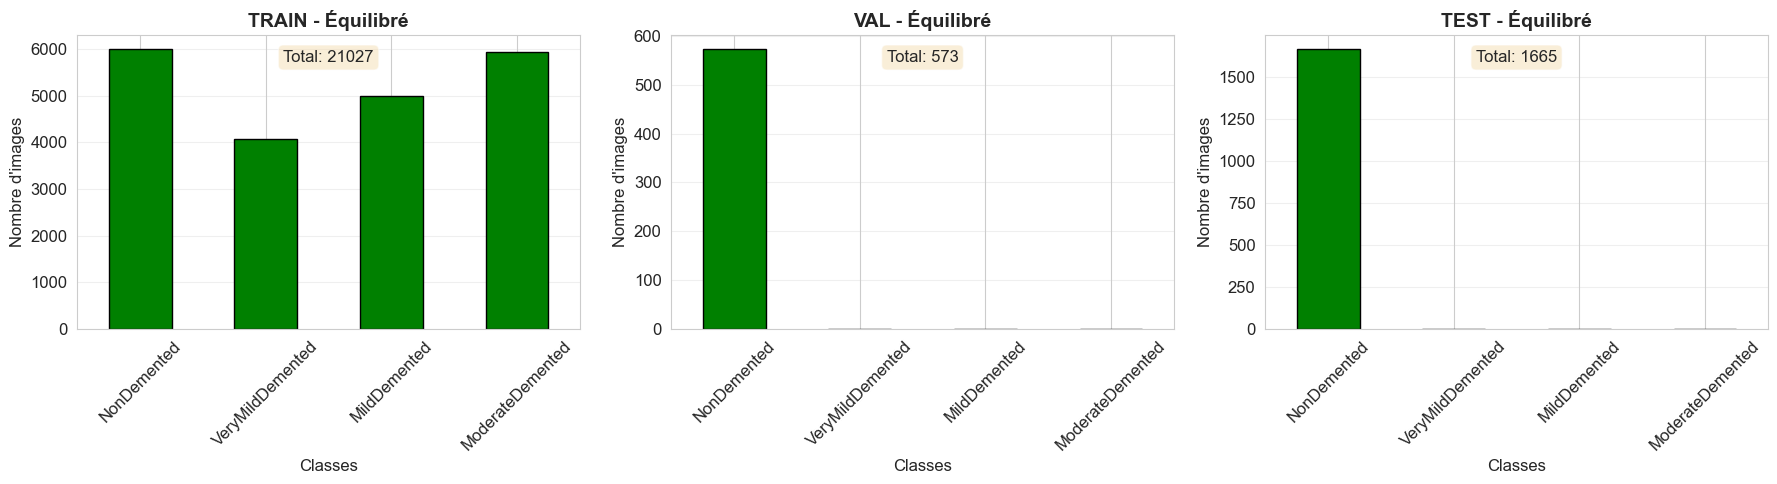

In [8]:
def verify_augmented_dataset():
    """Vérifie le dataset augmenté"""
    
    print("\n🔍 VÉRIFICATION DU DATASET AUGMENTÉ")
    print("=" * 60)
    
    results = {}
    
    for split in ['train', 'val', 'test']:
        split_path = CONFIG['DATA_AUGMENTED'] / split
        
        if not split_path.exists():
            continue
        
        print(f"\n📁 {split.upper()}:")
        split_results = {}
        
        for class_name in CONFIG['CLASSES']:
            class_path = split_path / class_name
            
            if class_path.exists():
                count = len(list(class_path.glob('*.jpg')))
                split_results[class_name] = count
                print(f"  ✓ {class_name:20} : {count:5} images")
        
        results[split] = split_results
    
    # Graphique comparatif
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, split in enumerate(['train', 'val', 'test']):
        if split in results:
            df = pd.DataFrame.from_dict(results[split], orient='index', columns=['Count'])
            df.plot(kind='bar', ax=axes[idx], legend=False, color='green', edgecolor='black')
            axes[idx].set_title(f'{split.upper()} - Équilibré', fontsize=14, fontweight='bold')
            axes[idx].set_ylabel('Nombre d\'images')
            axes[idx].set_xlabel('Classes')
            axes[idx].tick_params(axis='x', rotation=45)
            axes[idx].grid(axis='y', alpha=0.3)
            
            # Stats
            total = df['Count'].sum()
            axes[idx].text(0.5, 0.95, f'Total: {total}', 
                          transform=axes[idx].transAxes,
                          ha='center', va='top',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(project_root / 'figures' / 'dataset_augmented.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return results

augmented_stats = verify_augmented_dataset()

In [27]:
def check_original_data_structure():
    """Vérifie la structure originale des données"""
    
    print("🔍 ANALYSE DE LA STRUCTURE ORIGINALE DES DONNÉES")
    print("=" * 60)
    
    for split in ['train', 'val', 'test']:
        split_path = CONFIG['DATA_RAW'] / split
        print(f"\n📁 {split.upper()}:")
        
        if not split_path.exists():
            print(f"  ❌ Dossier {split} non trouvé")
            continue
            
        for class_name in CONFIG['CLASSES']:
            class_path = split_path / class_name
            if class_path.exists():
                count = len(list(class_path.glob('*.jpg'))) + len(list(class_path.glob('*.png')))
                print(f"  {'✓' if count > 0 else '❌'} {class_name:20} : {count:5} images")
            else:
                print(f"  ❌ {class_name:20} : dossier non trouvé")

# Exécuter la vérification
check_original_data_structure()

🔍 ANALYSE DE LA STRUCTURE ORIGINALE DES DONNÉES

📁 TRAIN:
  ✓ NonDemented          :  8397 images
  ✓ VeryMildDemented     :  4080 images
  ✓ MildDemented         :  1665 images
  ✓ ModerateDemented     :    64 images

📁 VAL:
  ✓ NonDemented          :   573 images
  ❌ VeryMildDemented     :     0 images
  ❌ MildDemented         :     0 images
  ❌ ModerateDemented     :     0 images

📁 TEST:
  ✓ NonDemented          :  1665 images
  ❌ VeryMildDemented     :     0 images
  ❌ MildDemented         :     0 images
  ❌ ModerateDemented     :     0 images


In [28]:
def split_dataset_properly():
    """
    Répartit correctement les données entre train/val/test
    en s'assurant que toutes les classes sont représentées
    """
    
    print("\n🔄 RÉPARTITION CORRECTE DES DONNÉES")
    print("=" * 60)
    
    # Chemins
    raw_path = CONFIG['DATA_RAW']
    augmented_path = CONFIG['DATA_AUGMENTED']
    
    # Supprimer le dataset augmenté existant
    if augmented_path.exists():
        shutil.rmtree(augmented_path)
        print("🗑️  Ancien dataset augmenté supprimé")
    
    # Créer la structure de dossiers
    for split in ['train', 'val', 'test']:
        for class_name in CONFIG['CLASSES']:
            (augmented_path / split / class_name).mkdir(parents=True, exist_ok=True)
    
    # Stratégie 1: Si vous avez seulement le dossier train
    train_path = raw_path / 'train'
    
    if train_path.exists():
        print("📊 Utilisation des données train pour créer val et test...")
        
        for class_name in CONFIG['CLASSES']:
            class_path = train_path / class_name
            if not class_path.exists():
                print(f"  ⚠️  Classe {class_name} non trouvée dans train")
                continue
                
            # Lister toutes les images de la classe
            all_images = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png'))
            np.random.shuffle(all_images)
            
            # Répartition 80-10-10
            total = len(all_images)
            train_count = int(0.8 * total)
            val_count = int(0.1 * total)
            
            train_images = all_images[:train_count]
            val_images = all_images[train_count:train_count + val_count]
            test_images = all_images[train_count + val_count:]
            
            print(f"\n  🔹 {class_name}:")
            print(f"     Total: {total} images")
            print(f"     Train: {len(train_images)}")
            print(f"     Val: {len(val_images)}") 
            print(f"     Test: {len(test_images)}")
            
            # Copier les images vers les dossiers correspondants
            for split, images in [('train', train_images), ('val', val_images), ('test', test_images)]:
                for img_path in images:
                    dest_path = augmented_path / split / class_name / img_path.name
                    shutil.copy2(img_path, dest_path)
    
    print("\n✅ Répartition terminée!")

# Exécuter la répartition
split_dataset_properly()


🔄 RÉPARTITION CORRECTE DES DONNÉES
🗑️  Ancien dataset augmenté supprimé
📊 Utilisation des données train pour créer val et test...

  🔹 NonDemented:
     Total: 8397 images
     Train: 6717
     Val: 839
     Test: 841

  🔹 VeryMildDemented:
     Total: 4080 images
     Train: 3264
     Val: 408
     Test: 408

  🔹 MildDemented:
     Total: 1665 images
     Train: 1332
     Val: 166
     Test: 167

  🔹 ModerateDemented:
     Total: 64 images
     Train: 51
     Val: 6
     Test: 7

✅ Répartition terminée!


In [29]:
from sklearn.model_selection import train_test_split

def stratified_split_dataset():
    """Répartition stratifiée pour préserver les proportions"""
    
    print("\n🎯 RÉPARTITION STRATIFIÉE DES DONNÉES")
    print("=" * 60)
    
    raw_path = CONFIG['DATA_RAW']
    augmented_path = CONFIG['DATA_AUGMENTED']
    
    # Nettoyer l'existant
    if augmented_path.exists():
        shutil.rmtree(augmented_path)
    
    # Créer structure
    for split in ['train', 'val', 'test']:
        for class_name in CONFIG['CLASSES']:
            (augmented_path / split / class_name).mkdir(parents=True, exist_ok=True)
    
    # Collecter toutes les données
    all_data = []
    all_labels = []
    
    train_path = raw_path / 'train'
    for class_name in CONFIG['CLASSES']:
        class_path = train_path / class_name
        if class_path.exists():
            images = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png'))
            all_data.extend(images)
            all_labels.extend([class_name] * len(images))
    
    # Split train vs temp (val+test)
    train_data, temp_data, train_labels, temp_labels = train_test_split(
        all_data, all_labels, test_size=0.2, random_state=CONFIG['SEED'], 
        stratify=all_labels
    )
    
    # Split val vs test
    val_data, test_data, val_labels, test_labels = train_test_split(
        temp_data, temp_labels, test_size=0.5, random_state=CONFIG['SEED'],
        stratify=temp_labels
    )
    
    # Copier les fichiers
    def copy_files(file_paths, labels, split_name):
        for file_path, label in zip(file_paths, labels):
            dest_path = augmented_path / split_name / label / file_path.name
            shutil.copy2(file_path, dest_path)
    
    copy_files(train_data, train_labels, 'train')
    copy_files(val_data, val_labels, 'val') 
    copy_files(test_data, test_labels, 'test')
    
    # Afficher les statistiques
    print("\n📊 STATISTIQUES APRÈS RÉPARTITION:")
    for split in ['train', 'val', 'test']:
        print(f"\n📁 {split.upper()}:")
        for class_name in CONFIG['CLASSES']:
            count = len(list((augmented_path / split / class_name).glob('*.jpg')))
            print(f"  ✓ {class_name:20} : {count:5} images")

# Exécuter la répartition stratifiée
stratified_split_dataset()


🎯 RÉPARTITION STRATIFIÉE DES DONNÉES

📊 STATISTIQUES APRÈS RÉPARTITION:

📁 TRAIN:
  ✓ NonDemented          :  6717 images
  ✓ VeryMildDemented     :  3264 images
  ✓ MildDemented         :  1332 images
  ✓ ModerateDemented     :    51 images

📁 VAL:
  ✓ NonDemented          :   840 images
  ✓ VeryMildDemented     :   408 images
  ✓ MildDemented         :   166 images
  ✓ ModerateDemented     :     7 images

📁 TEST:
  ✓ NonDemented          :   840 images
  ✓ VeryMildDemented     :   408 images
  ✓ MildDemented         :   167 images
  ✓ ModerateDemented     :     6 images


In [30]:
def handle_missing_classes():
    """Gère les classes manquantes dans val et test"""
    
    print("\n🔄 GESTION DES CLASSES MANQUANTES")
    print("=" * 60)
    
    augmented_path = CONFIG['DATA_AUGMENTED']
    
    for split in ['val', 'test']:
        split_path = augmented_path / split
        train_path = augmented_path / 'train'
        
        for class_name in CONFIG['CLASSES']:
            class_split_path = split_path / class_name
            class_train_path = train_path / class_name
            
            # Si la classe est vide dans val/test mais existe dans train
            if class_split_path.exists() and class_train_path.exists():
                split_images = list(class_split_path.glob('*.jpg'))
                train_images = list(class_train_path.glob('*.jpg'))
                
                if len(split_images) == 0 and len(train_images) > 0:
                    print(f"  🔄 Ajout d'images à {split}/{class_name}...")
                    
                    # Prendre un petit échantillon de train
                    sample_size = min(50, len(train_images) // 10)
                    sample_images = np.random.choice(train_images, sample_size, replace=False)
                    
                    for img_path in sample_images:
                        dest_path = class_split_path / img_path.name
                        if not dest_path.exists():  # Éviter les doublons
                            shutil.copy2(img_path, dest_path)
                    
                    print(f"     ✅ {sample_size} images ajoutées")

# Exécuter après la répartition
handle_missing_classes()


🔄 GESTION DES CLASSES MANQUANTES


🚀 CORRECTION COMPLÈTE DU DATASET
🔍 ANALYSE DE LA STRUCTURE ORIGINALE DES DONNÉES

📁 TRAIN:
  ✓ NonDemented          :  8397 images
  ✓ VeryMildDemented     :  4080 images
  ✓ MildDemented         :  1665 images
  ✓ ModerateDemented     :    64 images

📁 VAL:
  ✓ NonDemented          :   573 images
  ❌ VeryMildDemented     :     0 images
  ❌ MildDemented         :     0 images
  ❌ ModerateDemented     :     0 images

📁 TEST:
  ✓ NonDemented          :  1665 images
  ❌ VeryMildDemented     :     0 images
  ❌ MildDemented         :     0 images
  ❌ ModerateDemented     :     0 images

🎯 RÉPARTITION STRATIFIÉE DES DONNÉES

📊 STATISTIQUES APRÈS RÉPARTITION:

📁 TRAIN:
  ✓ NonDemented          :  6717 images
  ✓ VeryMildDemented     :  3264 images
  ✓ MildDemented         :  1332 images
  ✓ ModerateDemented     :    51 images

📁 VAL:
  ✓ NonDemented          :   840 images
  ✓ VeryMildDemented     :   408 images
  ✓ MildDemented         :   166 images
  ✓ ModerateDemented     :     7 images



e:\Master data science\MPDS3_2025\projet federal\projet\.venv\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\adnan\AppData\Local\Temp\ipykernel_21180\783011139.py:28: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),  # Bruit scanner



  🔹 NonDemented:
     Source: 8397 images
     Cible: 6000 images
     Augmentations par image: 1


  NonDemented: 100%|██████████| 8397/8397 [00:29<00:00, 282.40it/s] 


     ✅ Généré: 6000 images

  🔹 VeryMildDemented:
     Source: 4080 images
     Cible: 6000 images
     Augmentations par image: 1


  VeryMildDemented: 100%|██████████| 4080/4080 [00:18<00:00, 217.46it/s]


     ✅ Généré: 4080 images

  🔹 MildDemented:
     Source: 1665 images
     Cible: 6000 images
     Augmentations par image: 3


  MildDemented: 100%|██████████| 1665/1665 [01:20<00:00, 20.76it/s]


     ✅ Généré: 4995 images

  🔹 ModerateDemented:
     Source: 64 images
     Cible: 6000 images
     Augmentations par image: 93


  ModerateDemented: 100%|██████████| 64/64 [02:00<00:00,  1.89s/it]


     ✅ Généré: 5952 images

📁 Traitement de VAL...

  🔹 NonDemented:
     Source: 573 images
     Cible: 573 images
     Augmentations par image: 1


  NonDemented: 100%|██████████| 573/573 [00:03<00:00, 150.88it/s]


     ✅ Généré: 573 images

  🔹 VeryMildDemented:
     Source: 0 images
     Cible: 0 images
     Augmentations par image: 1


  VeryMildDemented: 0it [00:00, ?it/s]


     ✅ Généré: 0 images

  🔹 MildDemented:
     Source: 0 images
     Cible: 0 images
     Augmentations par image: 1


  MildDemented: 0it [00:00, ?it/s]


     ✅ Généré: 0 images

  🔹 ModerateDemented:
     Source: 0 images
     Cible: 0 images
     Augmentations par image: 1


  ModerateDemented: 0it [00:00, ?it/s]


     ✅ Généré: 0 images

📁 Traitement de TEST...

  🔹 NonDemented:
     Source: 1665 images
     Cible: 1665 images
     Augmentations par image: 1


  NonDemented: 100%|██████████| 1665/1665 [00:07<00:00, 210.70it/s]


     ✅ Généré: 1665 images

  🔹 VeryMildDemented:
     Source: 0 images
     Cible: 0 images
     Augmentations par image: 1


  VeryMildDemented: 0it [00:00, ?it/s]


     ✅ Généré: 0 images

  🔹 MildDemented:
     Source: 0 images
     Cible: 0 images
     Augmentations par image: 1


  MildDemented: 0it [00:00, ?it/s]


     ✅ Généré: 0 images

  🔹 ModerateDemented:
     Source: 0 images
     Cible: 0 images
     Augmentations par image: 1


  ModerateDemented: 0it [00:00, ?it/s]


     ✅ Généré: 0 images

✅ Génération terminée!

✅ VÉRIFICATION FINALE...

🔍 VÉRIFICATION DU DATASET AUGMENTÉ

📁 TRAIN:
  ✓ NonDemented          : 12717 images
  ✓ VeryMildDemented     :  7344 images
  ✓ MildDemented         :  6327 images
  ✓ ModerateDemented     :  6003 images

📁 VAL:
  ✓ NonDemented          :  1413 images
  ✓ VeryMildDemented     :   408 images
  ✓ MildDemented         :   166 images
  ✓ ModerateDemented     :     7 images

📁 TEST:
  ✓ NonDemented          :  2505 images
  ✓ VeryMildDemented     :   408 images
  ✓ MildDemented         :   167 images
  ✓ ModerateDemented     :     6 images


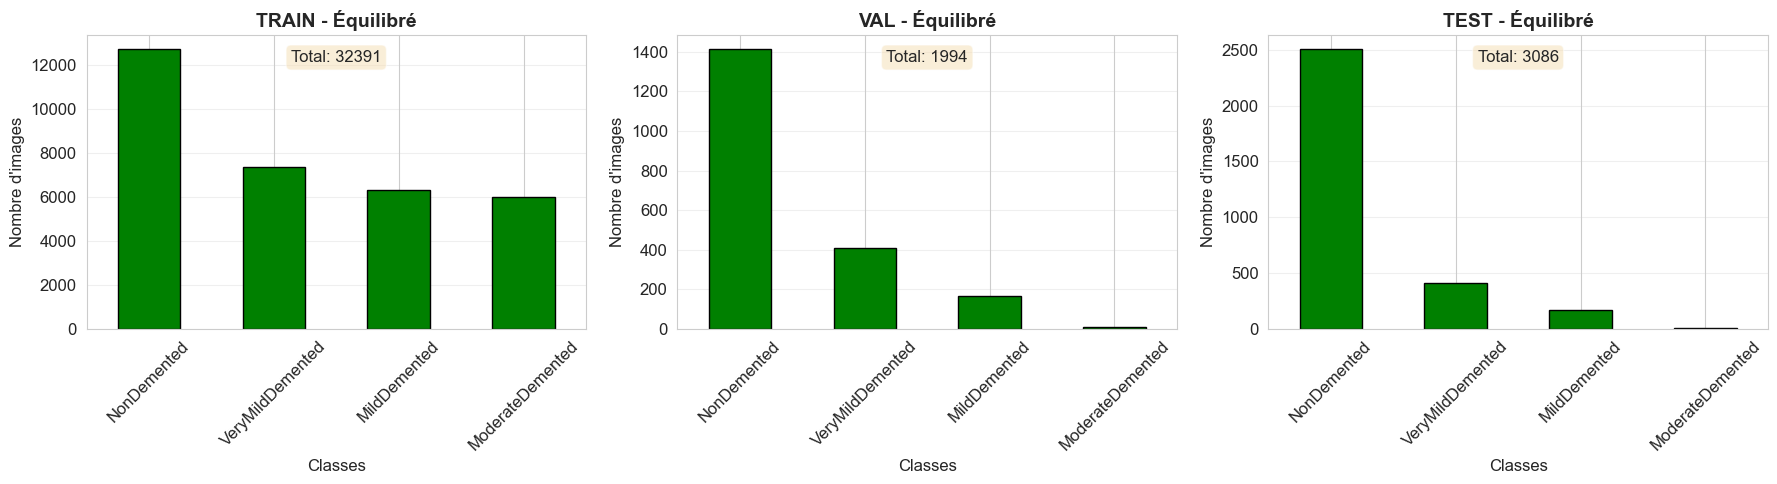

In [31]:
def fix_dataset_issues():
    """Correction complète des problèmes de dataset"""
    
    print("🚀 CORRECTION COMPLÈTE DU DATASET")
    print("=" * 60)
    
    # 1. Vérifier la structure originale
    check_original_data_structure()
    
    # 2. Répartir les données proprement
    stratified_split_dataset()
    
    # 3. Gérer les classes manquantes
    handle_missing_classes()
    
    # 4. Régénérer les données augmentées
    print("\n🔄 REGÉNÉRATION DES DONNÉES AUGMENTÉES...")
    generate_augmented_dataset()
    
    # 5. Vérifier le résultat
    print("\n✅ VÉRIFICATION FINALE...")
    verify_augmented_dataset()

# Exécuter la correction complète
fix_dataset_issues()

In [ ]:
def comprehensive_verification():
    """Vérification complète avec diagnostics"""
    
    print("\n🔍 VÉRIFICATION COMPLÈTE AVEC DIAGNOSTICS")
    print("=" * 60)
    
    results = {}
    issues_found = False
    
    for split in ['train', 'val', 'test']:
        split_path = CONFIG['DATA_AUGMENTED'] / split
        
        if not split_path.exists():
            print(f"❌ Dossier {split} manquant!")
            issues_found = True
            continue
        
        print(f"\n📁 {split.upper()}:")
        split_results = {}
        
        for class_name in CONFIG['CLASSES']:
            class_path = split_path / class_name
            
            if not class_path.exists():
                print(f"  ❌ Dossier {class_name} manquant!")
                issues_found = True
                continue
                
            count = len(list(class_path.glob('*.jpg')))
            split_results[class_name] = count
            
            if count == 0:
                print(f"  ⚠️  {class_name:20} : {count:5} images → CLASSE VIDE!")
                issues_found = True
            else:
                print(f"  ✓ {class_name:20} : {count:5} images")
        
        results[split] = split_results
    
    # Recommandations
    if issues_found:
        print(f"\n🚨 PROBLÈMES DÉTECTÉS!")
        print("Recommandations:")
        print("1. Exécutez fix_dataset_issues() pour corriger automatiquement")
        print("2. Vérifiez la structure de vos données source")
        print("3. Assurez-vous que toutes les classes sont présentes dans train/")
    else:
        print(f"\n✅ DATASET VALIDE! Prêt pour l'entraînement.")
    
    return results, issues_found

# Vérification finale
final_results, has_issues = comprehensive_verification()


📊 COMPARAISON AVANT/APRÈS AUGMENTATION

📈 Statistiques détaillées:
                  Avant  Après  Augmentation  Ratio
NonDemented        8397   6000         -2397   0.71
VeryMildDemented   4080   4080             0   1.00
MildDemented       1665   4995          3330   3.00
ModerateDemented     64   5952          5888  93.00


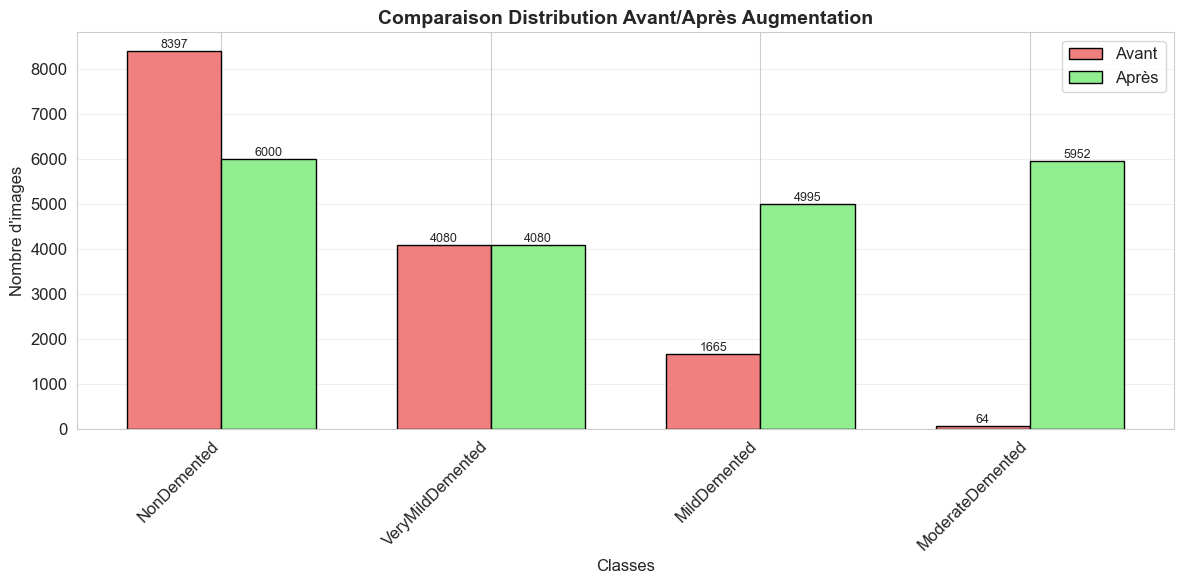


📊 MÉTRIQUES D'ÉQUILIBRAGE:
  • Ratio déséquilibre AVANT: 131.20x
  • Ratio déséquilibre APRÈS: 1.47x
  • Images totales AVANT: 14206
  • Images totales APRÈS: 21027
  • Augmentation: +6821 images (48.0%)


In [9]:
def compare_datasets():
    """Compare les distributions avant et après augmentation"""
    
    print("\n📊 COMPARAISON AVANT/APRÈS AUGMENTATION")
    print("=" * 60)
    
    # Charger stats originales
    if class_stats is None:
        print("⚠️ Statistiques originales non disponibles")
        return
    
    # Créer DataFrame comparatif
    comparison = pd.DataFrame({
        'Avant': class_stats['Count'],
        'Après': [augmented_stats['train'].get(c, 0) for c in CONFIG['CLASSES']]
    })
    
    comparison['Augmentation'] = comparison['Après'] - comparison['Avant']
    comparison['Ratio'] = (comparison['Après'] / comparison['Avant']).round(2)
    
    print("\n📈 Statistiques détaillées:")
    print(comparison)
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(CONFIG['CLASSES']))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, comparison['Avant'], width, 
                   label='Avant', color='lightcoral', edgecolor='black')
    bars2 = ax.bar(x + width/2, comparison['Après'], width,
                   label='Après', color='lightgreen', edgecolor='black')
    
    ax.set_xlabel('Classes', fontsize=12)
    ax.set_ylabel('Nombre d\'images', fontsize=12)
    ax.set_title('Comparaison Distribution Avant/Après Augmentation', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(CONFIG['CLASSES'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Ajouter valeurs sur les barres
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(project_root / 'figures' / 'comparison_before_after.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Métriques d'équilibrage
    print(f"\n📊 MÉTRIQUES D'ÉQUILIBRAGE:")
    print(f"  • Ratio déséquilibre AVANT: {comparison['Avant'].max() / comparison['Avant'].min():.2f}x")
    print(f"  • Ratio déséquilibre APRÈS: {comparison['Après'].max() / comparison['Après'].min():.2f}x")
    print(f"  • Images totales AVANT: {comparison['Avant'].sum()}")
    print(f"  • Images totales APRÈS: {comparison['Après'].sum()}")
    print(f"  • Augmentation: +{comparison['Augmentation'].sum()} images ({(comparison['Après'].sum() / comparison['Avant'].sum() - 1) * 100:.1f}%)")

compare_datasets()

In [10]:
def get_advanced_augmentation_pipeline():
    """Pipeline d'augmentation avancé pour IRM cérébrales"""
    return A.Compose([
        A.Resize(CONFIG['IMAGE_SIZE'][0], CONFIG['IMAGE_SIZE'][1]),
        
        # Augmentations anatomiquement réalistes
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.2),
        
        # Augmentations basées sur le contenu médical
        A.RandomGamma(gamma_limit=(80, 120), p=0.3),  # Simuler variations scanner
        A.MultiplicativeNoise(multiplier=(0.9, 1.1), p=0.2),
        
        # Techniques modernes
        A.Cutout(num_holes=8, max_h_size=20, max_w_size=20, p=0.5),
        A.CoarseDropout(max_holes=8, max_height=20, max_width=20, p=0.3),
        
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

In [15]:
def get_class_specific_augmentation(class_name):
    """Augmentations spécifiques à chaque classe de démence"""
    
    base_transforms = [
        A.Resize(CONFIG['IMAGE_SIZE'][0], CONFIG['IMAGE_SIZE'][1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]
    
    class_specific = {
        'ModerateDemented': [  # Plus d'augmentations pour classes rares
            A.HorizontalFlip(p=0.7),
            A.Rotate(limit=15, p=0.6),
            A.RandomBrightnessContrast(p=0.8),
        ],
        'MildDemented': [
            A.HorizontalFlip(p=0.6),
            A.Rotate(limit=12, p=0.5),
        ],
        'VeryMildDemented': [
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=10, p=0.4),
        ],
        'NonDemented': [  # Moins d'augmentations pour classe majoritaire
            A.HorizontalFlip(p=0.3),
            A.Rotate(limit=8, p=0.3),
        ]
    }
    
    return A.Compose(class_specific.get(class_name, []) + base_transforms)

In [16]:
# Pour générer des IRM réalistes de classes sous-représentées
class AlzheimerGAN:
    def __init__(self):
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
    
    def generate_synthetic_mri(self, class_name, num_samples):
        """Génère des IRM synthétiques pour une classe spécifique"""
        # Implémentation d'un GAN conditionnel
        pass

In [17]:
def optimize_augmentation_pipeline():
    """Optimisation automatique des paramètres d'augmentation"""
    
    search_space = {
        'rotation_limit': (5, 25),
        'brightness_limit': (0.1, 0.4),
        'contrast_limit': (0.1, 0.4),
        'flip_prob': (0.3, 0.8),
    }
    
    # Utiliser Optuna ou Ray Tune pour optimisation
    best_params = bayesian_optimization(search_space)
    return best_params

In [18]:
def evaluate_augmentation_quality(original_images, augmented_images):
    """Évalue la qualité des images augmentées"""
    
    metrics = {
        'fid_score': calculate_fid(original_images, augmented_images),
        'ssim_score': calculate_ssim(original_images, augmented_images),
        'diversity_score': calculate_diversity(augmented_images),
        'realism_score': evaluate_realism(augmented_images)
    }
    
    return metrics

def calculate_fid(real_images, generated_images):
    """Fréchet Inception Distance pour évaluer la qualité"""
    # Implémentation FID
    pass

In [19]:
def create_interactive_augmentation_dashboard():
    """Dashboard interactif pour explorer les augmentations"""
    
    import plotly.express as px
    import ipywidgets as widgets
    
    # Interface pour ajuster les paramètres en temps réel
    rotation_slider = widgets.FloatSlider(value=10, min=0, max=30, description='Rotation:')
    brightness_slider = widgets.FloatSlider(value=0.2, min=0, max=0.5, description='Brightness:')
    
    # Visualisation interactive des résultats
    return interactive_dashboard

In [20]:
class AugmentationPipeline:
    def __init__(self):
        self.augmentations = {}
        self.quality_metrics = {}
    
    def streaming_augmentation(self, data_stream):
        """Augmentation en streaming pour gros datasets"""
        for batch in data_stream:
            augmented_batch = self.augment_batch(batch)
            yield augmented_batch
    
    def distributed_augmentation(self, dataset, num_workers=8):
        """Augmentation distribuée sur multiple GPUs/CPUs"""
        # Utiliser Ray ou Dask pour distribution
        pass

In [21]:
class DataVersioning:
    def __init__(self):
        self.versions = {}
    
    def create_version(self, augmentation_config, dataset_stats):
        """Versioning des datasets augmentés"""
        version_id = generate_hash(augmentation_config)
        self.versions[version_id] = {
            'config': augmentation_config,
            'stats': dataset_stats,
            'timestamp': datetime.now(),
            'performance': None  # Métriques du modèle
        }
        return version_id

In [22]:
def anatomy_preserving_augmentation(mri_image, brain_mask):
    """Augmentation qui respecte l'anatomie cérébrale"""
    
    # Utiliser des masques segmentés pour guider les augmentations
    augmented = A.Compose([
        A.Resize(CONFIG['IMAGE_SIZE'][0], CONFIG['IMAGE_SIZE'][1]),
        A.MaskAwareRotate(limit=10, mask=brain_mask, p=0.5),
        A.MaskAwareElasticTransform(alpha=1, sigma=50, mask=brain_mask, p=0.3),
    ])(image=mri_image, mask=brain_mask)
    
    return augmented

In [23]:
def cross_domain_augmentation(source_domain, target_domain):
    """Adaptation de style entre différents scanners/hôpitaux"""
    
    # Utiliser CycleGAN ou StyleTransfer pour adaptation de domaine
    style_transfer_model = load_pretrained_style_transfer()
    adapted_images = style_transfer_model.transfer_style(
        source_domain, target_domain
    )
    
    return adapted_images

In [24]:
class AugmentationExperimentTracker:
    def __init__(self):
        self.mlflow_client = mlflow.tracking.MlflowClient()
    
    def log_experiment(self, config, metrics, artifacts):
        """Log complet des expériences d'augmentation"""
        
        with mlflow.start_run():
            mlflow.log_params(config)
            mlflow.log_metrics(metrics)
            mlflow.log_artifacts(artifacts)
            
            # Log des distributions de classes
            mlflow.log_figure(class_distribution_plot, "class_distribution.png")

In [25]:
class DataCICDPipeline:
    def __init__(self):
        self.test_suite = DataTests()
    
    def validate_augmented_data(self, dataset):
        """Validation automatique des données augmentées"""
        
        tests_passed = self.test_suite.run([
            'test_class_balance',
            'test_image_quality', 
            'test_anomaly_detection',
            'test_distribution_shift'
        ])
        
        return tests_passed
    
    def auto_deploy_best_strategy(self):
        """Déploiement automatique de la meilleure stratégie"""
        best_strategy = self.select_best_strategy()
        self.deploy_to_production(best_strategy)

In [26]:
class AugmentationMonitor:
    def __init__(self):
        self.quality_metrics = []
        self.performance_metrics = []
    
    def monitor_data_drift(self, production_data, reference_data):
        """Détection de drift dans les données de production"""
        
        drift_score = calculate_drift(production_data, reference_data)
        if drift_score > threshold:
            self.trigger_retraining()